In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pylab as py

## Campo de um dipolo

In [2]:
#criando grid. Atemporal
xmin = -3000
xmax = 3000
nx = 200

ymin = -3000
ymax = 3000
ny = 200

x = np.linspace(xmin, xmax, nx) # metros
y = np.linspace(ymin, ymax, ny) # metros
z = 0 # metros
X,Y = np.meshgrid(x,y)

In [3]:
def retornaB_dipolo(m_v, x , y, xc=0, yc=0, zc=-1000,z=0):
    C=10e-7                                                # henry/m
    
    r = np.sqrt( (x-xc)**2 + (y-yc)**2 + (z-zc)**2 )       # metros
    m = np.sqrt(m_v[0]**2 + m_v[1]**2 + m_v[2]**2)         # Am²
    cos_theta = (m_v[0]*x + m_v[1]*y + m_v[2]*zc)/(r*m)
    
    return C*m*3*cos_theta/(r*r*r)                         #T

In [4]:
#campo magnético de um dipolo
#localização
xc = 0                                  # metros
yc = 0                                  # metros
zc = -800                               # metros
m_v = np.array([5e15,7e15,8e5])         # vetor de m que é em Am²

B_dipolo = retornaB_dipolo(m_v,X,Y)     # T
B_dipolo = B_dipolo*10e9                # nT

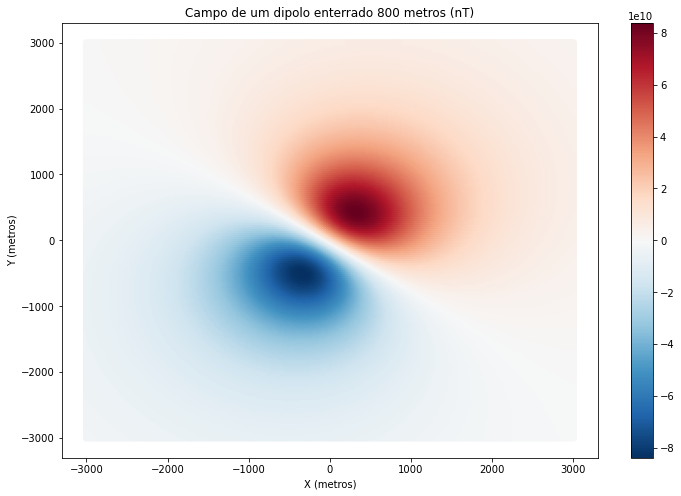

In [5]:
py.rcParams['figure.figsize'] = (12.0, 8.0) #Redimensiona a figura
plt.scatter(X,Y,c=B_dipolo,cmap = plt.cm.RdBu_r)
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('Campo de um dipolo enterrado %i metros (nT)'%-zc)
plt.colorbar()
plt.show()

## Variação Diurna

In [6]:
#F = 23500.0 # Campo regional em nT

def variacaoDiurna(h,F,vB,i=0,f=1):
    if 6. <= h <= 18.:
        return F + vB * np.sin((np.pi/12.0) * (h-6.0) ) + random.normalvariate(i, f)
    else:
        return F + random.normalvariate(i,f)

F = np.median(B_dipolo)       # Campo médio regional em nT
vB = 30.0                     # amplitude da variacao diurna em nT

hora = np.linspace(0.0, 24.0, 1000, endpoint=True)
B_diurno = []
for h in hora:
    B = variacaoDiurna(h,F,vB)
    B_diurno.append(B)

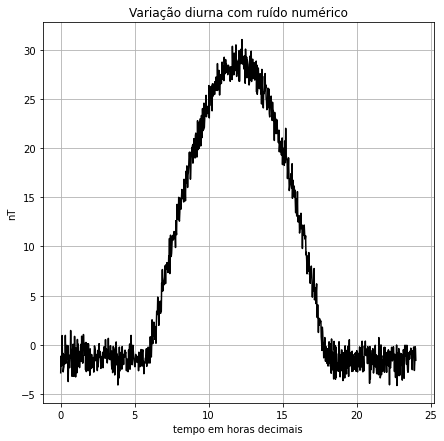

In [7]:
plt.figure(figsize=(7,7))
plt.plot(hora, B_diurno, 'k-',)
plt.xlabel('tempo em horas decimais')
plt.title("Variação diurna com ruído numérico")
plt.grid()
plt.ylabel('nT')
plt.show()

## Simulação de uma aquisição. Dados em função do tempo

In [8]:
#criando grid de observações em função do tempo
passos_x = 100
passos_y = 300

#matrizes com os dados. primeira linha é x, segunda é y, terceira é B medido e quarta é o tempo
magnetometroMovel_xyBt = [[],[],[],[]]
magnetometroBase_Bt = [[],[]]           #fixado em (0,0)

t = 6 #horas da manhã
print("Hora de início:",t)

for x in range(xmin,xmax,passos_x):
    for y in range(ymin,ymax+1,passos_y):
        
        t += 0.005 #espaçamento temporal entre cada ponto
        r = np.sqrt( (x-xc)**2 + (y-yc)**2 + (z-zc)**2 )
        
        #dados magnetometro movel
        #dado adquirido é a resultante do campo gerado pelo dipolo com o campo gerado pelo ionização da atmosfera, obviamente com ruido
        magnetometroMovel_xyBt[0] += [x]
        magnetometroMovel_xyBt[1] += [y]
        magnetometroMovel_xyBt[2] += [retornaB_dipolo(m_v,x,y) + variacaoDiurna(t,F,vB)]
        magnetometroMovel_xyBt[3] += [t]
        
        #dados magnetometro base
        magnetometroBase_Bt[0] += [retornaB_dipolo(m_v,0,0) + variacaoDiurna(t,F,vB)]
        magnetometroBase_Bt[1] += [t]        
        
    # simulando o movimento de um veiculo, então o carro faz linhas paralelas S/N "indo" e depois N/S "voltando"
    yminX = ymin
    ymin,ymax,passos_y = ymax,yminX,-passos_y
        
print("Hora de término:",t)

Hora de início: 6
Hora de término: 12.150000000000606


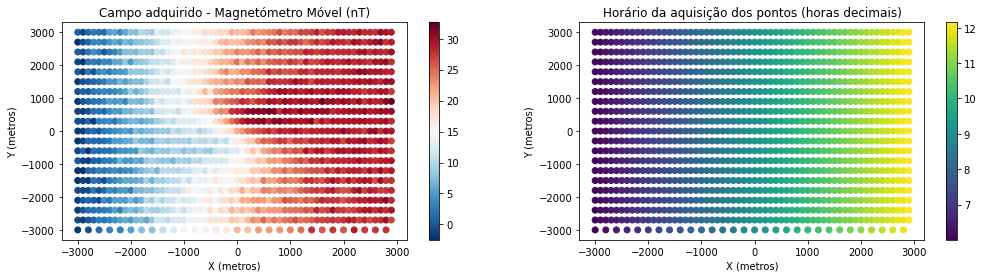

In [9]:
# vizualizacao do grid de observacoes em função do tempo
py.rcParams['figure.figsize'] = (17.0, 4.0) #Redimensiona a figura

plt.subplot(1, 2, 1)
plt.scatter(magnetometroMovel_xyBt[0],magnetometroMovel_xyBt[1],c=magnetometroMovel_xyBt[2],cmap = plt.cm.RdBu_r)
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('Campo adquirido - Magnetómetro Móvel (nT)')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(magnetometroMovel_xyBt[0],magnetometroMovel_xyBt[1],c=magnetometroMovel_xyBt[3])
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('Horário da aquisição dos pontos (horas decimais)')
plt.colorbar()

plt.show()

## Redução: Variação Diurna

In [12]:
media_mensal = F
residuo = []

dadoReduzido_xyBt = np.copy(magnetometroMovel_xyBt)
dadoReduzido_xyBt[2] = magnetometroMovel_xyBt[2] - (magnetometroBase_Bt[0]-media_mensal)

for i in range(len(magnetometroMovel_xyBt[0])):
    residuo.append( dadoReduzido_xyBt[2][i] - retornaB_dipolo(m_v,x,y) )   

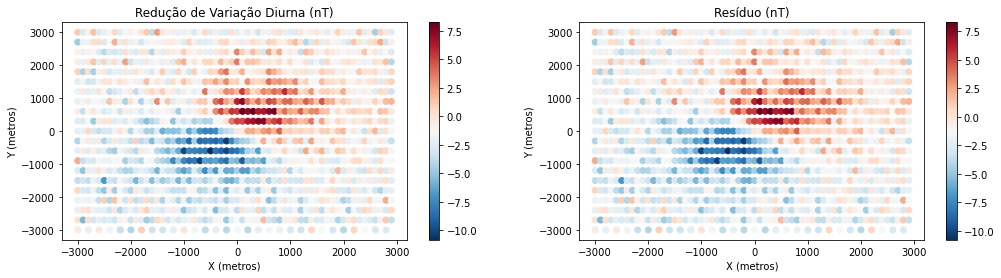

In [13]:
# vizualizacao do grid de observacoes em função do tempo
py.rcParams['figure.figsize'] = (17.0, 4.0) #Redimensiona a figura

plt.subplot(1, 2, 1)
plt.scatter(dadoReduzido_xyBt[0],dadoReduzido_xyBt[1],c=dadoReduzido_xyBt[2],cmap = plt.cm.RdBu_r)
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('Redução de Variação Diurna (nT)')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(dadoReduzido_xyBt[0],dadoReduzido_xyBt[1],c=residuo,cmap = plt.cm.RdBu_r)
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('Resíduo (nT)')
plt.colorbar()

plt.show()